In [64]:
from dataset import LargeMovieDataset
from cnn import SentimentCNN, trainingModelCNN
from sklearn.feature_extraction.text import TfidfVectorizer
from dataset import LargeMovieDataset
from gensim.models import Word2Vec
from utils import get_sentences_data, check_dir, train
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
MODELS_DIR = '../models'
check_dir(MODELS_DIR)
# Create dataset
word_embedding_size = 16
word2vec_model = Word2Vec.load(f'{MODELS_DIR}/word2vec_model.model')

train_set = LargeMovieDataset(path='../../aclImdb_v1/', set='train', embedding_dic=word2vec_model.wv, word_embedding_size=word_embedding_size)
test_set = LargeMovieDataset(path='../../aclImdb_v1/', set='test', embedding_dic=word2vec_model.wv, word_embedding_size=word_embedding_size)


max_len: 999
max_len: 1000


In [3]:

# split the training set into training and validation set (80 for training, 20 for validation)
train_set, validation_set = torch.utils.data.random_split(train_set, [int(len(train_set) * 0.8), len(train_set) - int(len(train_set) * 0.8)])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

print("Data loaded")
print('Training set size:', len(train_set))
print('Validation set size:', len(validation_set))
print('Test set size:', len(test_set))


Data loaded
Training set size: 19976
Validation set size: 4995
Test set size: 24987


In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from torch.functional import F

# no need embedding layer, we use word2vec
class SentimentCNN(nn.Module):
    def __init__(self, len_word, hidden_size, num_classes, dropout=0.5):
        super().__init__()       
        # create a cnn 
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=len_word, out_channels=hidden_size, kernel_size=k, dtype=torch.double, stride=1) for k in [3, 4, 5]])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*3, num_classes, dtype=torch.double)

    def forward(self, x):
        #x = torch.unsqueeze(x, dim=1)
        x.transpose_(1, 2)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        # requied shape for fc layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return torch.sigmoid(x).squeeze()


def trainingModelCNN(model, training_dataloader, valid_dataloader, criterion, optimizer, num_epochs=10):
    model = model.to(device)
    loss_list = []
    for epoch in range(num_epochs):
        logging_loss = 0.0
        for i, data in enumerate(training_dataloader):
            input = data['data']
            labels = data['label']

            input = input.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            out = model(input)

            # Compute loss
            loss = criterion(out, labels)

            # Compute gradients
            loss.backward()

            # Backward pass - model update
            optimizer.step()

            logging_loss += loss.item()
            if i % len(training_dataloader) == len(training_dataloader) - 1:
                # Logging training loss
                logging_loss /= len(training_dataloader)
                print('Training loss epoch ', epoch, ' -- mini-batch ', i, ': ', logging_loss)
                logging_loss = 0.0
            
                # Model validation
                with torch.no_grad():
                    logging_loss_val = 0.0
                    for i, data_val in enumerate(valid_dataloader):
                        input_val = data_val['data']
                        labels_val = data_val['label']

                        input_val = input_val.to(device)
                        labels_val = labels_val.to(device)

                        out_val = model(input_val)

                        loss_val = criterion(out_val, labels_val)

                        logging_loss_val += loss_val.item()
                    logging_loss_val /= len(valid_dataloader)
                    loss_list.append(logging_loss_val)
                    print('Validation loss: ', logging_loss_val)
    return loss_list

In [84]:
cnnModel = SentimentCNN(len_word=word_embedding_size, hidden_size=100, num_classes=2, dropout=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnnModel.parameters(), lr=0.001)

loss_list = trainingModelCNN(cnnModel, train_loader, validation_loader, criterion, optimizer, num_epochs=20)

# save model 
torch.save(cnnModel.state_dict(), f'{MODELS_DIR}/cnnModel.pt')

Training loss epoch  0  -- mini-batch  624 :  0.6926463916639609
Validation loss:  0.690610407491777
Training loss epoch  1  -- mini-batch  624 :  0.6667820472744805
Validation loss:  0.6363554964322481
Training loss epoch  2  -- mini-batch  624 :  0.6085634942755445
Validation loss:  0.5844567953288963
Training loss epoch  3  -- mini-batch  624 :  0.5743563136365376
Validation loss:  0.5640057795633431
Training loss epoch  4  -- mini-batch  624 :  0.5496944980770955
Validation loss:  0.5550126276453019
Training loss epoch  5  -- mini-batch  624 :  0.5329380150906466
Validation loss:  0.5396184113017447
Training loss epoch  6  -- mini-batch  624 :  0.5216413528083945
Validation loss:  0.5307849545971096
Training loss epoch  7  -- mini-batch  624 :  0.511027724868899
Validation loss:  0.5225347640391057
Training loss epoch  8  -- mini-batch  624 :  0.5062165904562458
Validation loss:  0.5399319197974813
Training loss epoch  9  -- mini-batch  624 :  0.4976079598842257
Validation loss:  0

None


ValueError: x, y, and format string must not be None

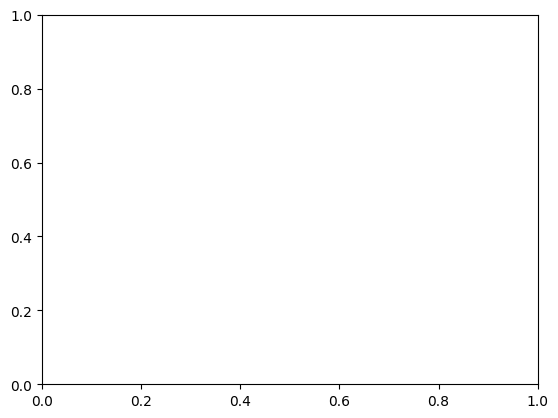

In [86]:
# print loss
import matplotlib.pyplot as plt
print(loss_list)
plt.plot(loss_list)
plt.show()

In [83]:
# test accuracy with the test set
test_accuracy = 0
for i, data in enumerate(test_loader):
    inputs = data['data']
    labels = data['label']

    predictions = cnnModel(inputs)
    _, predictions = torch.max(predictions, 2)
    test_accuracy += torch.sum(predictions == labels) / labels.size()[0]
test_accuracy /= len(test_loader)
print('Test accuracy:', test_accuracy.item())


KeyError: "Key 'dehling' not present"